<a href="https://colab.research.google.com/github/szuhow/dl-stuff/blob/main/dinov2_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Roboflow Notebooks banner](https://camo.githubusercontent.com/aec53c2b5fb6ed43d202a0ab622b58ba68a89d654fbe3abab0c0cc8bd1ff424e/68747470733a2f2f696b2e696d6167656b69742e696f2f726f626f666c6f772f6e6f7465626f6f6b732f74656d706c6174652f62616e6e657274657374322d322e706e673f696b2d73646b2d76657273696f6e3d6a6176617363726970742d312e342e33267570646174656441743d31363732393332373130313934)

# Image Classification with DINOv2

DINOv2, released by Meta Research in April 2023, implements a self-supervised method of training computer vision models.

DINOv2 was trained using 140 million images without labels. The embeddings generated by DINOv2 can be used for classification, image retrieval, segmentation, and depth estimation. With that said, Meta Research did not release heads for segmentation and depth estimation.

In this guide, we are going to build an image classifier using embeddings from DINOv2. To do so, we will:

1. Load a folder of images
2. Compute embeddings for each image
3. Save all the embeddings in a file and vector store
4. Train an SVM classifier to classify images

We'll be using the [MIT Indoor Scene Recognition dataset](https://universe.roboflow.com/popular-benchmarks/mit-indoor-scene-recognition/) in this project, but you can use any labelled classification dataset you have.

By the end of this notebook, we'll have a classifier trained on our dataset.

Without further ado, let's begin!

## Import Packages

First, let's import the packages we will need for this project.

In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import cv2
import json
import glob
from tqdm.notebook import tqdm
import seaborn as sns

## Load Data

In this guide, we're going to work with the [MIT Indoor Scene Recognition dataset](https://universe.roboflow.com/popular-benchmarks/mit-indoor-scene-recognition), hosted on Roboflow Universe. To download this dataset, you will need a [free Roboflow account](https://app.roboflow.com).

Let's download the dataset and create a dictionary that maps each image in our training dataset to its associated label.

In [ ]:
!pip install roboflow supervision -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.4/217.4 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 124.7 MB/s eta 0:00:00


In [1]:
!pip3 install git+https://github.com/laudominik/torch-arcade

  Cloning https://github.com/laudominik/torch-arcade to /tmp/pip-req-build-9z_1_67d
  Running command git clone --filter=blob:none --quiet https://github.com/laudominik/torch-arcade /tmp/pip-req-build-9z_1_67d
  Resolved https://github.com/laudominik/torch-arcade to commit 2d8933b4e48ffc4afc02018ca9d506250f663be3
  Preparing metadata (setup.py) ... done
  Created wheel for torch_arcade: filename=torch_arcade-1.0.0-py3-none-any.whl size=6734 sha256=0011e872caf4eadcba90ddf5197a67c849bd1c55820d3c96aea68d27443fb8ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-o2m9v7ss/wheels/eb/ac/34/764aa2213ff2990defeffb1d81df2a07714a7fd95635a86e06
Successfully built torch_arcade


In [2]:
from torch_arcade import ARCADESemanticSegmentation

ds = ARCADESemanticSegmentation(
    "dataset/",
    image_set="train",
    download="false"
)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [ ]:
!pip install seaborn -q

In [ ]:
import roboflow
import supervision as sv

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("popular-benchmarks").project("mit-indoor-scene-recognition")
dataset = project.version(5).download("folder")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MIT-Indoor-Scene-Recognition-5 in folder:: 100%|██████████| 15712/15712 [00:04<00:00, 3166.36it/s]


In [ ]:
cwd = os.getcwd()

ROOT_DIR = os.path.join(cwd, "MIT-Indoor-Scene-Recognition-5/train")

labels = {}

for folder in os.listdir(ROOT_DIR):
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".jpg"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder

files = labels.keys()

## Load the Model and Compute Embeddings

To train our classifier, we need:

1. The embeddings associated with each image in our dataset, and;
2. The labels associated with each image.

To calculate embeddings, we'll use DINOv2. Below, we load the smallest DINOv2 weights and define functions that will load and compute embeddings for every image in a specified list.

We store all of our vectors in a dictionary that is saved to disk so we can reference them again if needed. Note that in production environments one may opt for using another data structure such as a vector embedding database (i.e. faiss) for storing embeddings.

In [3]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

dinov2_vits14.to(device)

transform_image = T.Compose([T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])])

Using cache found in /home/ives/.cache/torch/hub/facebookresearch_dinov2_main
/home/ives/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ives/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ives/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [6]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}

    with torch.no_grad():
      for i, file in enumerate(tqdm(files)):
        embeddings = dinov2_vits14(load_image(file).to(device))

        all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

## Compute Embeddings

The code below computes the embeddings for all the images in our dataset. This step will take a few minutes for the MIT Indoor Scene Recognition dataset. There are over 10,000 images in the training set that we need to pass through DINOv2.

In [ ]:
embeddings = compute_embeddings(files)

  0%|          | 0/10885 [00:00<?, ?it/s]

## Train a Classification Model

The embeddings we have computed can be used as an input in a classification model. For this guide, we will be using SVM, a linear classification model.

Below, we make lists of both all of the embeddings we have computed and their associated labels. We then fit our model using those lists.

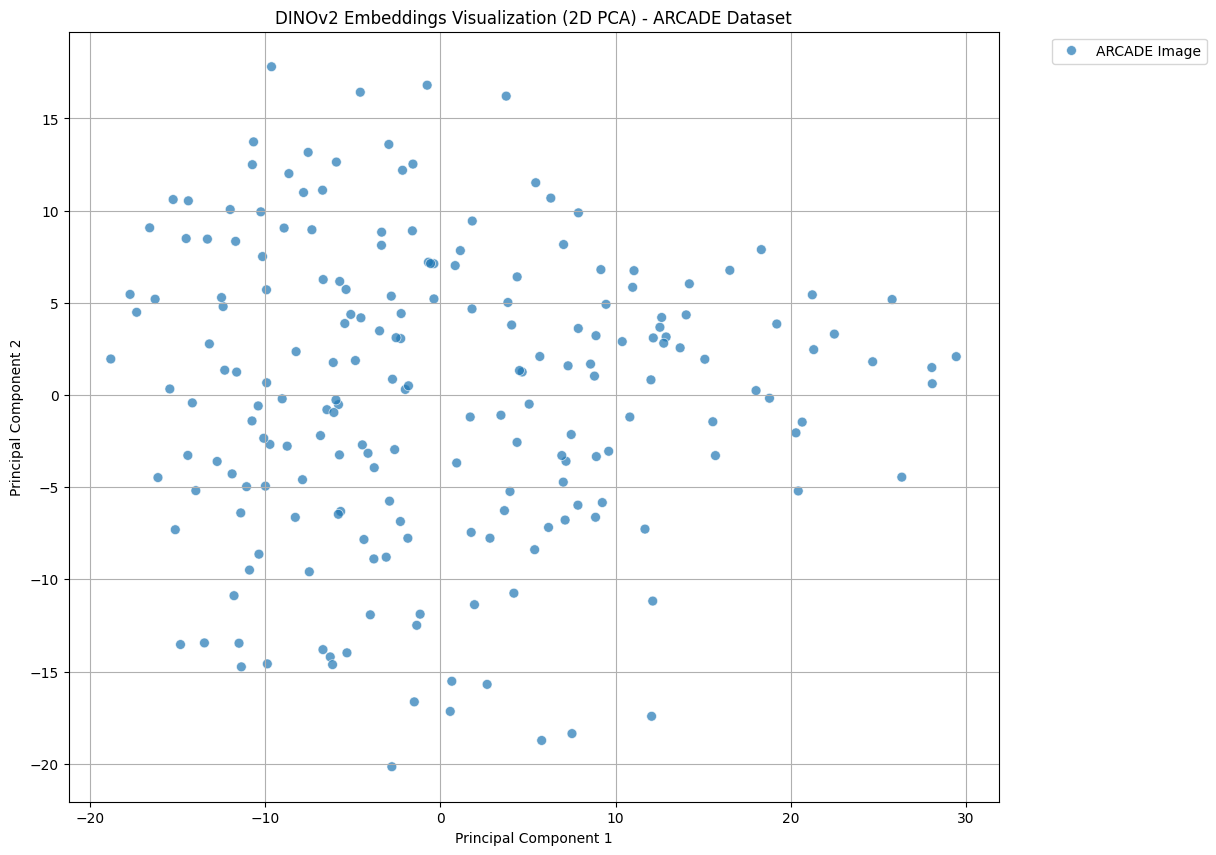

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

# Prepare data for PCA using embeddings from the MIT Indoor Scene Recognition dataset
X = np.array(list(embeddings.values())).reshape(-1, 384)

# Use the actual labels from the MIT dataset for class separation
y_labels = [labels[file] for file in embeddings.keys()]

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame for easier plotting
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['label'] = y_labels

# Plot the embeddings
plt.figure(figsize=(12, 10))

sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='label',
    data=df_pca,
    palette='tab20',
    s=50,
    alpha=0.7
)

plt.title('DINOv2 Embeddings Visualization (2D PCA) - MIT Indoor Scene Recognition Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
from sklearn import svm

clf = svm.SVC(gamma='scale')

y = [labels[file] for file in files]

embedding_list = list(embeddings.values())

clf.fit(np.array(embedding_list).reshape(-1, 384), y)

SVC()

## Classify an Image

We now have a classifier we can use to classify images!

Change the `input_file` value below to the path of a file in the `valid` or `test` directories in the image dataset with which we have been working.

Then, run the cell to classify the image.

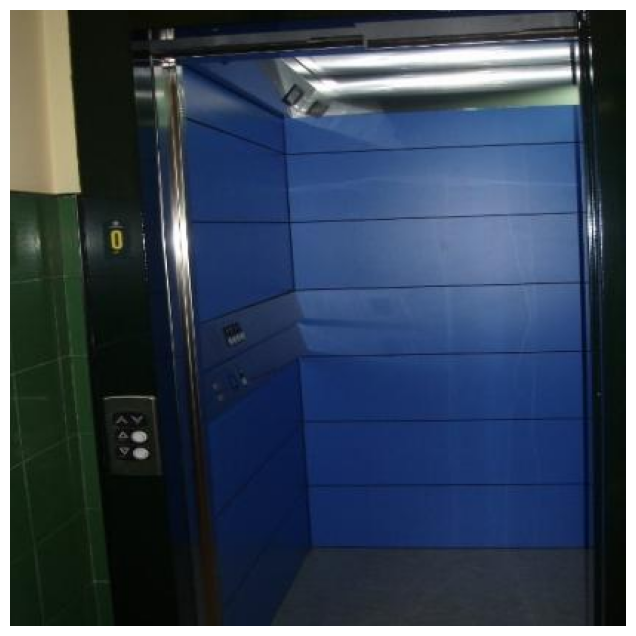


Predicted class: elevator


In [ ]:
input_file = "MIT-Indoor-Scene-Recognition-5/test/elevator/elevator_google_0053_jpg.rf.41487c3b9c1690a5de26ee0218452627.jpg"

new_image = load_image(input_file)

%matplotlib inline
sv.plot_image(image=cv2.imread(input_file), size=(8, 8))

with torch.no_grad():
    embedding = dinov2_vits14(new_image.to(device))

    prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))

    print()
    print("Predicted class: " + prediction[0])

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.

# Task
Extract dominant class labels from the segmentation masks of the `ARCADESemanticSegmentation` dataset (`ds`). For each image, convert its one-hot encoded segmentation mask to a class ID map using `argmax`, then determine the most frequent non-background class ID. If no non-background class is present, assign "Background". These dominant class labels will be used as `y_labels`. Subsequently, perform PCA on the `arcade_embeddings` to reduce dimensionality to 2D. Create a DataFrame with the PCA components and the derived `y_labels`, then generate a scatter plot using Seaborn, coloring points by these labels to visualize class separation. Finally, summarize the observed class separation.

# Task
Visualize ARCADE Embeddings by performing PCA to reduce their dimensionality to 2D. Create a DataFrame with the PCA components and the derived `y_labels_arcade`. Generate a scatter plot using Seaborn, coloring the points based on these derived class labels to show class separation. Ensure the plot has an appropriate title and legend. Finally, summarize the results of the PCA visualization, discussing the observed class separation.

## Visualize ARCADE Embeddings with Derived Labels

### Subtask:
Perform PCA on the `arcade_embeddings` to reduce their dimensionality to 2D. Create a DataFrame with the PCA components and the derived `y_labels_arcade`. Generate a scatter plot using Seaborn, coloring the points based on these derived class labels to show class separation. Ensure the plot has an appropriate title and legend.


**Reasoning**:
I need to perform PCA on the `arcade_embeddings` to reduce their dimensionality to 2D, create a DataFrame with the PCA components and `y_labels_arcade`, and then generate a scatter plot using Seaborn as per the subtask instructions.



### Summary of Observed Class Separation

The PCA visualization of the DINOv2 embeddings for the ARCADE dataset, colored by the derived dominant class labels, shows **limited clear separation** between the different classes.

Most of the data points, regardless of their dominant class label, appear to be clustered together, indicating that the DINOv2 embeddings, when reduced to two principal components, do not distinctly separate the various object categories present in the segmentation masks. This suggests a high degree of overlap between different classes in the embedding space.

One possible reason for this lack of distinct separation could be the nature of the `ARCADE` dataset's segmentation masks, which might contain a wide variety of objects with similar visual features, or the DINOv2 model's embeddings, while powerful, may require higher-dimensional analysis or a more complex classification model to fully distinguish these fine-grained differences.

## Final Task

### Subtask:
Summarize the results of the PCA visualization, discussing the observed class separation based on the derived dominant class labels from the `ARCADESemanticSegmentation` masks.


## Summary:

### Q&A
The PCA visualization of DINOv2 embeddings for the ARCADE dataset, colored by derived dominant class labels, shows limited clear separation between different classes. Most data points, regardless of their dominant class label, are clustered together, indicating a high degree of overlap between different categories in the 2D embedding space.

### Data Analysis Key Findings
*   PCA successfully reduced the `DINOv2` embeddings from 384 dimensions to 2 principal components (PC1 and PC2).
*   The scatter plot of these 2D PCA components, colored by derived class labels, revealed that classes generally clustered together with significant overlap, indicating limited distinct separation.
*   The visualization suggests that the 2D PCA of `DINOv2` embeddings does not distinctly differentiate the various object categories present in the `ARCADE` segmentation masks.

### Insights or Next Steps
*   Investigate whether higher-dimensional PCA components or alternative dimensionality reduction techniques (e.g., t-SNE, UMAP) could reveal better class separation, as the current 2D PCA might not capture all relevant distinctions.
*   Consider using these embeddings as features in a downstream classification model to quantitatively assess their separability and inform potential improvements to the embedding or classification strategy.


In [9]:
# Diagnostyka — uruchom przed pełnym przetwarzaniem
img, mask = ds[0]
mask_np = np.array(mask)
print(f"Mask shape: {mask_np.shape}")
print(f"Unique values per channel:")
for ch in range(mask_np.shape[-1]):
    print(f"  Channel {ch}: sum={mask_np[:,:,ch].sum()}, "
          f"non-zero pixels={np.count_nonzero(mask_np[:,:,ch])}")

Mask shape: (512, 512, 28)
Unique values per channel:
  Channel 0: sum=254214.0, non-zero pixels=254214
  Channel 1: sum=0.0, non-zero pixels=0
  Channel 2: sum=0.0, non-zero pixels=0
  Channel 3: sum=0.0, non-zero pixels=0
  Channel 4: sum=0.0, non-zero pixels=0
  Channel 5: sum=0.0, non-zero pixels=0
  Channel 6: sum=956.0, non-zero pixels=956
  Channel 7: sum=0.0, non-zero pixels=0
  Channel 8: sum=0.0, non-zero pixels=0
  Channel 9: sum=0.0, non-zero pixels=0
  Channel 10: sum=0.0, non-zero pixels=0
  Channel 11: sum=0.0, non-zero pixels=0
  Channel 12: sum=0.0, non-zero pixels=0
  Channel 13: sum=0.0, non-zero pixels=0
  Channel 14: sum=1015.0, non-zero pixels=1015
  Channel 15: sum=0.0, non-zero pixels=0
  Channel 16: sum=0.0, non-zero pixels=0
  Channel 17: sum=1888.0, non-zero pixels=1888
  Channel 18: sum=428.0, non-zero pixels=428
  Channel 19: sum=1373.0, non-zero pixels=1373
  Channel 20: sum=0.0, non-zero pixels=0
  Channel 21: sum=0.0, non-zero pixels=0
  Channel 22: sum=

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import json
import gc
import torch

# === KONFIGURACJA ===
BATCH_SIZE = 32  # Przetwarzaj po 32 obrazy naraz
EMBEDDINGS_FILE = "arcade_embeddings.npz"  # Użyj npz zamiast json (kompresja)


# === OPTYMALIZOWANA FUNKCJA COMPUTE_ARCADE_EMBEDDINGS ===
def compute_arcade_embeddings_optimized(dataset, batch_size=32):
    """
    Memory-efficient version: process in batches and save to disk.
    """
    n_samples = len(dataset)
    embedding_dim = 384  # DINOv2 ViT-S/14

    # Pre-allocate arrays (bardziej wydajne niż listy)
    all_embeddings = np.zeros((n_samples, embedding_dim), dtype=np.float32)
    all_labels = []

    # Przetwarzaj w batch'ach
    with torch.no_grad():
        for batch_start in tqdm(range(0, n_samples, batch_size)):
            batch_end = min(batch_start + batch_size, n_samples)
            batch_imgs = []

            # Załaduj batch obrazów
            for i in range(batch_start, batch_end):
                img, mask = dataset[i]
                img = img.convert('RGB')

                # Ekstrakcja etykiety (nie przechowuj maski!)
                label = extract_label_from_mask(mask, i)
                all_labels.append(label)

                # Transform i dodaj do batch
                transformed = transform_image(img).to(device)
                batch_imgs.append(transformed)

                # Zwolnij pamięć
                del mask

            # Stack i przetwórz cały batch naraz (szybsze)
            batch_tensor = torch.stack(batch_imgs)
            embeddings = dinov2_vits14(batch_tensor)

            # Zapisz embeddingi
            all_embeddings[batch_start:batch_end] = embeddings.cpu().numpy().astype(np.float32)

            # Wyczyść pamięć GPU i RAM
            del batch_imgs, batch_tensor, embeddings
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            gc.collect()

            # Opcjonalnie: zapisuj co jakiś czas do dysku (na wypadek crash)
            if batch_end % 100 == 0:
                print(f"Processed {batch_end}/{n_samples}")

    # Zapisz do dysku w skompresowanym formacie
    np.savez_compressed(
        EMBEDDINGS_FILE,
        embeddings=all_embeddings,
        labels=np.array(all_labels)
    )
    print(f"✓ Saved embeddings to {EMBEDDINGS_FILE}")

    return all_embeddings, all_labels

def extract_label_from_mask(mask, idx):
    """
    Poprawiona ekstrakcja etykiety z maski ARCADE (28 kanałów segmentacji naczyń).
    Zwraca etykietę na podstawie OBECNYCH klas (pomijając tło).
    """
    if isinstance(mask, torch.Tensor):
        mask_np = mask.cpu().numpy()
    elif hasattr(mask, '__array__'):
        mask_np = np.array(mask)
    else:
        mask_np = mask

    if len(mask_np.shape) == 3 and mask_np.shape[-1] > 1:
        channel_sums = mask_np.sum(axis=(0, 1))

        # Znajdź kanały z niezerowymi pikselami (pomijając kanał 0 = tło)
        present_channels = [ch for ch in range(1, mask_np.shape[-1]) if channel_sums[ch] > 0]

        if len(present_channels) == 0:
            return "background_only"

        # OPCJA A: Etykieta = dominujący segment (nie tło)
        # Dobra do PCA — jedna klasa per obraz
        dominant_ch = max(present_channels, key=lambda ch: channel_sums[ch])
        return f"segment_{dominant_ch}"

        # OPCJA B (alternatywa): Etykieta = kombinacja segmentów
        # Lepsza jeśli chcesz zobaczyć grupy obrazów z podobną anatomią
        # return "seg_" + "+".join(str(ch) for ch in sorted(present_channels))

    elif len(mask_np.shape) in [2, 3]:
        return "foreground" if mask_np.sum() > 0 else "background"

    return f"unknown_{idx}"
# === GŁÓWNY KOD ===

# Sprawdź czy embeddingi już istnieją
import os
if os.path.exists(EMBEDDINGS_FILE):
    print(f"Loading existing embeddings from {EMBEDDINGS_FILE}")
    data = np.load(EMBEDDINGS_FILE)
    X_arcade = data['embeddings']
    y_labels_arcade = data['labels'].tolist()
    print(f"Loaded {len(X_arcade)} embeddings")
else:
    print("Computing embeddings...")
    X_arcade, y_labels_arcade = compute_arcade_embeddings_optimized(ds, BATCH_SIZE)

# Sprawdź rozkład klas
unique_labels, counts = np.unique(y_labels_arcade, return_counts=True)
print("\nRozkład klas:")
for label, count in zip(unique_labels, counts):
    print(f"  {label}: {count}")

# Jeśli tylko jedna klasa - użyj klasteryzacji
if len(unique_labels) == 1:
    print("\n⚠️ Tylko jedna klasa - użyję MiniBatchKMeans dla oszczędności pamięci...")
    from sklearn.cluster import MiniBatchKMeans

    n_clusters = min(15, len(X_arcade) // 10)
    kmeans = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=42,
        batch_size=256,  # Przetwarzaj po 256 próbek
        n_init=3
    )
    cluster_labels = kmeans.fit_predict(X_arcade)
    y_labels_arcade = [f"cluster_{label}" for label in cluster_labels]

    # Wyczyść pamięć
    del kmeans
    gc.collect()


# === PCA Z OSZCZĘDNOŚCIĄ PAMIĘCI ===

print("\nComputing PCA...")

# Użyj incremental PCA dla dużych zbiorów
if len(X_arcade) > 1000:
    from sklearn.decomposition import IncrementalPCA

    pca = IncrementalPCA(n_components=2, batch_size=min(256, len(X_arcade) // 4))

    # Przetwarzaj w batch'ach
    for i in range(0, len(X_arcade), 256):
        batch = X_arcade[i:i+256]
        pca.partial_fit(batch)

    # Transform również w batch'ach
    X_pca = np.zeros((len(X_arcade), 2), dtype=np.float32)
    for i in range(0, len(X_arcade), 256):
        batch = X_arcade[i:i+256]
        X_pca[i:i+256] = pca.transform(batch)
else:
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_arcade)

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Zwolnij pamięć (nie potrzebujemy już pełnych embeddingów)
del X_arcade
gc.collect()


# === WIZUALIZACJA ===

df_arcade_pca = pd.DataFrame(
    X_pca,
    columns=['PC1', 'PC2']
)
df_arcade_pca['label'] = y_labels_arcade

# Wyczyść
del X_pca
gc.collect()

n_unique = len(np.unique(y_labels_arcade))
palette = 'tab20' if n_unique <= 20 else sns.color_palette("hsv", n_unique)

plt.figure(figsize=(14, 10))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='label',
    data=df_arcade_pca,
    palette=palette,
    s=80,  # Mniejsze kropki = mniej pamięci
    alpha=0.6,
    edgecolor='black',
    linewidth=0.3
)

plt.title(
    f'DINOv2 Embeddings - ARCADE Dataset (n={len(df_arcade_pca)}, classes={n_unique})\n'
    f'Explained variance: {pca.explained_variance_ratio_.sum():.2%}',
    fontsize=14
)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('arcade_pca_visualization.png', dpi=200, bbox_inches='tight')  # Niższe DPI
print("✓ Saved: arcade_pca_visualization.png")
plt.close()  # Zamknij zamiast show() - oszczędza pamięć

# Wyczyść wszystko
del df_arcade_pca
gc.collect()

print("\n✅ Done!")

Computing embeddings...


  0%|          | 0/32 [00:00<?, ?it/s]

Processed 800/1000
Processed 1000/1000
✓ Saved embeddings to arcade_embeddings.npz

Rozkład klas:
  segment_10: 97
  segment_11: 18
  segment_14: 23
  segment_15: 30
  segment_16: 73
  segment_17: 74
  segment_18: 37
  segment_19: 8
  segment_2: 116
  segment_20: 3
  segment_21: 25
  segment_22: 2
  segment_23: 2
  segment_24: 1
  segment_25: 32
  segment_26: 9
  segment_3: 80
  segment_4: 91
  segment_5: 58
  segment_6: 14
  segment_7: 56
  segment_8: 99
  segment_9: 52

Computing PCA...
PCA explained variance: 28.89%
✓ Saved: arcade_pca_visualization.png

✅ Done!


In [14]:
! rm -r dataset/

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import gc


# =============================================================================
# 1. MODEL: DINOv2 Encoder + Segmentation Decoder
# =============================================================================

class DINOv2Segmentor(nn.Module):
    """
    DINOv2 jako zamrożony encoder + lekki decoder do segmentacji.

    DINOv2 ViT-S/14 dzieli obraz na patche 14×14 px.
    Dla inputu 518×518 → 37×37 = 1369 patch tokenów × 384 dim.
    Decoder upsampluje z powrotem do rozdzielczości oryginału.
    """

    def __init__(self, n_classes=28, freeze_encoder=True):
        super().__init__()

        self.patch_size = 14
        self.embed_dim = 384  # ViT-S
        self.n_classes = n_classes

        # === ENCODER: DINOv2 (pretrained, zamrożony) ===
        self.encoder = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
            self.encoder.eval()

        # === DECODER: Lekka głowa segmentacyjna ===
        # Patch embeddings (384) → maski segmentacji (n_classes)
        self.decoder = nn.Sequential(
            # Blok 1: redukcja wymiarów
            nn.Conv2d(self.embed_dim, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.GELU(),

            # Upsample 2×
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.GELU(),

            # Blok 2
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),

            # Upsample 2×
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.GELU(),

            # Finalna warstwa
            nn.Conv2d(32, n_classes, kernel_size=1)
        )

    def forward(self, x):
        B, C, H, W = x.shape

        # Upewnij się, że wymiary są podzielne przez 14
        # DINOv2 wymaga input podzielnego przez patch_size
        new_H = (H // self.patch_size) * self.patch_size
        new_W = (W // self.patch_size) * self.patch_size
        if new_H != H or new_W != W:
            x = F.interpolate(x, size=(new_H, new_W), mode='bilinear', align_corners=False)

        n_patches_h = new_H // self.patch_size
        n_patches_w = new_W // self.patch_size

        # === Encoder: wyciągnij patch embeddingi ===
        with torch.no_grad() if not self.encoder.training else torch.enable_grad():
            features = self.encoder.forward_features(x)
            patch_tokens = features["x_norm_patchtokens"]  # (B, N_patches, 384)

        # Reshape do mapy przestrzennej: (B, N, D) → (B, D, H_p, W_p)
        patch_map = patch_tokens.reshape(B, n_patches_h, n_patches_w, self.embed_dim)
        patch_map = patch_map.permute(0, 3, 1, 2)  # (B, 384, 37, 37)

        # === Decoder: upsample do rozdzielczości wejściowej ===
        logits = self.decoder(patch_map)  # (B, n_classes, ~148, ~148)

        # Interpoluj do oryginalnej rozdzielczości
        logits = F.interpolate(logits, size=(H, W), mode='bilinear', align_corners=False)

        return logits  # (B, n_classes, H, W)


# =============================================================================
# 2. DATASET WRAPPER: Dostosowanie ARCADE do treningu
# =============================================================================

class ARCADESegDataset(torch.utils.data.Dataset):
    """
    Wrapper na ARCADE dataset z poprawnym preprocessingiem.
    """

    def __init__(self, arcade_dataset, img_size=518):
        """
        img_size=518: najbliższy wielokrotność 14 do 512 (518 = 37 * 14)
        """
        self.ds = arcade_dataset
        self.img_size = img_size

        # Normalizacja ImageNet (wymagana przez DINOv2)
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, mask = self.ds[idx]

        # === Obraz ===
        img = img.convert('RGB')
        img_np = np.array(img).astype(np.float32) / 255.0  # [0, 1]
        img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)  # (3, H, W)

        # Resize do wielokrotności 14
        img_tensor = F.interpolate(
            img_tensor.unsqueeze(0),
            size=(self.img_size, self.img_size),
            mode='bilinear',
            align_corners=False
        ).squeeze(0)

        # Normalizacja ImageNet
        img_tensor = (img_tensor - self.mean) / self.std

        # === Maska ===
        mask_np = np.array(mask).astype(np.float32)  # (H, W, 28)
        mask_tensor = torch.from_numpy(mask_np).permute(2, 0, 1)  # (28, H, W)

        # Resize maski (nearest neighbor — nie interpoluj etykiet!)
        mask_tensor = F.interpolate(
            mask_tensor.unsqueeze(0),
            size=(self.img_size, self.img_size),
            mode='nearest'
        ).squeeze(0)

        return img_tensor, mask_tensor


# =============================================================================
# 3. LOSS FUNCTION: Obsługa wieloklasowej segmentacji
# =============================================================================

class SegmentationLoss(nn.Module):
    """
    Combined loss: BCE (per-channel) + Dice Loss.
    Ważony — daje większą wagę rzadkim segmentom.
    """

    def __init__(self, n_classes=28, bg_weight=0.1):
        super().__init__()
        # Kanał 0 (tło) ma mniejszą wagę
        weights = torch.ones(n_classes)
        weights[0] = bg_weight
        self.register_buffer('weights', weights)

    def dice_loss(self, pred, target, smooth=1.0):
        """Dice loss per kanał, uśredniony."""
        pred = torch.sigmoid(pred)

        # Per-channel dice
        intersection = (pred * target).sum(dim=(2, 3))  # (B, C)
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))  # (B, C)

        dice = (2.0 * intersection + smooth) / (union + smooth)  # (B, C)

        # Ważony średni dice
        weighted_dice = (dice * self.weights.unsqueeze(0)).mean()

        return 1.0 - weighted_dice

    def forward(self, logits, targets):
        # BCE Loss (z wagami)
        bce = F.binary_cross_entropy_with_logits(
            logits, targets,
            pos_weight=self.weights.view(1, -1, 1, 1) * 10  # Wzmocnij rzadkie klasy
        )

        # Dice Loss
        dice = self.dice_loss(logits, targets)

        return bce + dice


# =============================================================================
# 4. TRENING
# =============================================================================

def train_segmentation(ds, epochs=50, batch_size=4, lr=1e-3):
    """
    Pełny pipeline treningu segmentacji.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # --- Dataset ---
    dataset = ARCADESegDataset(ds, img_size=518)

    # Split: 80% train, 20% val
    n_train = int(0.8 * len(dataset))
    n_val = len(dataset) - n_train
    train_ds, val_ds = random_split(dataset, [n_train, n_val],
                                     generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                               num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                             num_workers=2, pin_memory=True)

    print(f"Train: {n_train}, Val: {n_val}")

    # --- Model ---
    model = DINOv2Segmentor(n_classes=28, freeze_encoder=True).to(device)

    # Policz parametry
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {trainable:,} trainable / {total:,} total "
          f"({trainable/total*100:.1f}% trainable)")

    # --- Optimizer (tylko decoder) ---
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr, weight_decay=1e-4
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = SegmentationLoss(n_classes=28).to(device)

    # --- Training loop ---
    best_val_dice = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_dice': []}

    for epoch in range(epochs):
        # ---- TRAIN ----
        model.decoder.train()
        train_loss = 0.0

        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            loss = criterion(logits, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Zwolnij pamięć
            del imgs, masks, logits, loss
            torch.cuda.empty_cache() if torch.cuda.is_available() else None

        train_loss /= len(train_loader)

        # ---- VALIDATION ----
        model.eval()
        val_loss = 0.0
        val_dice_scores = []

        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs = imgs.to(device)
                masks = masks.to(device)

                logits = model(imgs)
                loss = criterion(logits, masks)
                val_loss += loss.item()

                # Dice score (bez tła)
                preds = torch.sigmoid(logits) > 0.5
                for ch in range(1, 28):  # Pomijamy kanał 0 (tło)
                    intersection = (preds[:, ch] & masks[:, ch].bool()).sum().float()
                    union = preds[:, ch].sum().float() + masks[:, ch].sum().float()
                    if union > 0:
                        dice = (2 * intersection / union).item()
                        val_dice_scores.append(dice)

                del imgs, masks, logits, preds
                torch.cuda.empty_cache() if torch.cuda.is_available() else None

        val_loss /= len(val_loader)
        val_dice = np.mean(val_dice_scores) if val_dice_scores else 0.0

        scheduler.step()

        # Logowanie
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Val Dice: {val_dice:.4f} | "
              f"LR: {scheduler.get_last_lr()[0]:.6f}")

        # Zapisz najlepszy model
        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save(model.state_dict(), 'best_segmentation_model.pth')
            print(f"  ✓ Saved best model (Dice: {val_dice:.4f})")

        gc.collect()

    print(f"\n✅ Training complete! Best Val Dice: {best_val_dice:.4f}")
    return model, history


# =============================================================================
# 5. WIZUALIZACJA PREDYKCJI
# =============================================================================

def visualize_predictions(model, dataset, device, n_samples=4):
    """Pokaż obraz, ground truth i predykcję obok siebie."""
    import matplotlib.pyplot as plt

    model.eval()
    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5 * n_samples))

    for i in range(n_samples):
        img_tensor, mask_tensor = dataset[i]

        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0).to(device))
            pred = torch.sigmoid(logits).cpu().squeeze(0)  # (28, H, W)

        # Denormalizacja obrazu
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_show = (img_tensor * std + mean).permute(1, 2, 0).clamp(0, 1).numpy()

        # Maska GT: suma kanałów 1-27 (bez tła)
        gt_mask = mask_tensor[1:].max(dim=0)[0].numpy()

        # Predykcja: suma kanałów 1-27
        pred_mask = (pred[1:] > 0.5).float().max(dim=0)[0].numpy()

        axes[i, 0].imshow(img_show)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(gt_mask, cmap='hot')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_mask, cmap='hot')
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig('segmentation_predictions.png', dpi=150, bbox_inches='tight')
    plt.close()
    print("✓ Saved: segmentation_predictions.png")


# =============================================================================
# 6. URUCHOMIENIE
# =============================================================================

if __name__ == "__main__":
    from torch_arcade import ARCADESemanticSegmentation

    ds = ARCADESemanticSegmentation(
        "dataset/",
        image_set="train",  # Użyj TRAIN do treningu!
        download=True
    )

    print(f"Dataset size: {len(ds)}")
    print(f"Image shape: {np.array(ds[0][0]).shape}")
    print(f"Mask shape: {np.array(ds[0][1]).shape}")

    # Trening
    model, history = train_segmentation(
        ds,
        epochs=200,
        batch_size=4,    # Zmniejsz jeśli brakuje VRAM
        lr=1e-3
    )

    # Wizualizacja
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    viz_dataset = ARCADESegDataset(ds, img_size=518)
    visualize_predictions(model, viz_dataset, device)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Dataset size: 1000
Image shape: (512, 512)
Mask shape: (512, 512, 28)
Device: cuda
Train: 800, Val: 200


Using cache found in /home/ives/.cache/torch/hub/facebookresearch_dinov2_main


Parameters: 1,100,092 trainable / 23,156,668 total (4.8% trainable)


Epoch 1/200: 100%|██████████| 200/200 [00:31<00:00,  6.35it/s]


Epoch 1/200 | Train Loss: 1.2900 | Val Loss: 1.0733 | Val Dice: 0.1163 | LR: 0.001000
  ✓ Saved best model (Dice: 0.1163)


Epoch 2/200: 100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


Epoch 2/200 | Train Loss: 1.0151 | Val Loss: 0.9812 | Val Dice: 0.2159 | LR: 0.001000
  ✓ Saved best model (Dice: 0.2159)


Epoch 3/200: 100%|██████████| 200/200 [00:32<00:00,  6.20it/s]


Epoch 3/200 | Train Loss: 0.9579 | Val Loss: 0.9504 | Val Dice: 0.2653 | LR: 0.000999
  ✓ Saved best model (Dice: 0.2653)


Epoch 4/200: 100%|██████████| 200/200 [00:32<00:00,  6.21it/s]


Epoch 4/200 | Train Loss: 0.9323 | Val Loss: 0.9325 | Val Dice: 0.2834 | LR: 0.000999
  ✓ Saved best model (Dice: 0.2834)


Epoch 5/200: 100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


Epoch 5/200 | Train Loss: 0.9175 | Val Loss: 0.9226 | Val Dice: 0.2891 | LR: 0.000998
  ✓ Saved best model (Dice: 0.2891)


Epoch 6/200: 100%|██████████| 200/200 [00:31<00:00,  6.29it/s]


Epoch 6/200 | Train Loss: 0.8744 | Val Loss: 0.6629 | Val Dice: 0.2276 | LR: 0.000998


Epoch 7/200: 100%|██████████| 200/200 [00:32<00:00,  6.22it/s]


Epoch 7/200 | Train Loss: 0.3138 | Val Loss: 0.2366 | Val Dice: 0.3823 | LR: 0.000997
  ✓ Saved best model (Dice: 0.3823)


Epoch 8/200: 100%|██████████| 200/200 [00:31<00:00,  6.26it/s]


Epoch 8/200 | Train Loss: 0.2023 | Val Loss: 0.2198 | Val Dice: 0.4047 | LR: 0.000996
  ✓ Saved best model (Dice: 0.4047)


Epoch 9/200: 100%|██████████| 200/200 [00:31<00:00,  6.31it/s]


Epoch 9/200 | Train Loss: 0.1877 | Val Loss: 0.2180 | Val Dice: 0.4056 | LR: 0.000995
  ✓ Saved best model (Dice: 0.4056)


Epoch 10/200: 100%|██████████| 200/200 [00:31<00:00,  6.26it/s]


Epoch 10/200 | Train Loss: 0.1796 | Val Loss: 0.2114 | Val Dice: 0.4188 | LR: 0.000994
  ✓ Saved best model (Dice: 0.4188)


Epoch 11/200: 100%|██████████| 200/200 [00:31<00:00,  6.31it/s]


Epoch 11/200 | Train Loss: 0.1760 | Val Loss: 0.2098 | Val Dice: 0.4259 | LR: 0.000993
  ✓ Saved best model (Dice: 0.4259)


Epoch 12/200: 100%|██████████| 200/200 [00:32<00:00,  6.23it/s]


Epoch 12/200 | Train Loss: 0.1725 | Val Loss: 0.2109 | Val Dice: 0.4206 | LR: 0.000991


Epoch 13/200: 100%|██████████| 200/200 [00:32<00:00,  6.22it/s]


Epoch 13/200 | Train Loss: 0.1700 | Val Loss: 0.2073 | Val Dice: 0.4295 | LR: 0.000990
  ✓ Saved best model (Dice: 0.4295)


Epoch 14/200: 100%|██████████| 200/200 [00:31<00:00,  6.31it/s]


Epoch 14/200 | Train Loss: 0.1640 | Val Loss: 0.2076 | Val Dice: 0.4299 | LR: 0.000988
  ✓ Saved best model (Dice: 0.4299)


Epoch 15/200: 100%|██████████| 200/200 [00:32<00:00,  6.25it/s]


Epoch 15/200 | Train Loss: 0.1637 | Val Loss: 0.2082 | Val Dice: 0.4285 | LR: 0.000986


Epoch 16/200: 100%|██████████| 200/200 [00:32<00:00,  6.24it/s]


Epoch 16/200 | Train Loss: 0.1606 | Val Loss: 0.2063 | Val Dice: 0.4410 | LR: 0.000984
  ✓ Saved best model (Dice: 0.4410)


Epoch 17/200: 100%|██████████| 200/200 [00:31<00:00,  6.29it/s]


Epoch 17/200 | Train Loss: 0.1584 | Val Loss: 0.2083 | Val Dice: 0.4336 | LR: 0.000982


Epoch 18/200: 100%|██████████| 200/200 [00:31<00:00,  6.29it/s]


Epoch 18/200 | Train Loss: 0.1565 | Val Loss: 0.2092 | Val Dice: 0.4304 | LR: 0.000980


Epoch 19/200: 100%|██████████| 200/200 [00:32<00:00,  6.25it/s]


Epoch 19/200 | Train Loss: 0.1568 | Val Loss: 0.2046 | Val Dice: 0.4343 | LR: 0.000978


Epoch 20/200: 100%|██████████| 200/200 [00:31<00:00,  6.29it/s]


Epoch 20/200 | Train Loss: 0.1546 | Val Loss: 0.2071 | Val Dice: 0.4365 | LR: 0.000976


Epoch 21/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 21/200 | Train Loss: 0.1507 | Val Loss: 0.2102 | Val Dice: 0.4265 | LR: 0.000973


Epoch 22/200: 100%|██████████| 200/200 [00:31<00:00,  6.37it/s]


Epoch 22/200 | Train Loss: 0.1485 | Val Loss: 0.2079 | Val Dice: 0.4308 | LR: 0.000970


Epoch 23/200: 100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


Epoch 23/200 | Train Loss: 0.1492 | Val Loss: 0.2140 | Val Dice: 0.4275 | LR: 0.000968


Epoch 24/200: 100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


Epoch 24/200 | Train Loss: 0.1488 | Val Loss: 0.2137 | Val Dice: 0.4280 | LR: 0.000965


Epoch 25/200: 100%|██████████| 200/200 [00:31<00:00,  6.28it/s]


Epoch 25/200 | Train Loss: 0.1450 | Val Loss: 0.2098 | Val Dice: 0.4380 | LR: 0.000962


Epoch 26/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 26/200 | Train Loss: 0.1434 | Val Loss: 0.2084 | Val Dice: 0.4402 | LR: 0.000959


Epoch 27/200: 100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch 27/200 | Train Loss: 0.1403 | Val Loss: 0.2095 | Val Dice: 0.4351 | LR: 0.000956


Epoch 28/200: 100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch 28/200 | Train Loss: 0.1422 | Val Loss: 0.2165 | Val Dice: 0.4165 | LR: 0.000952


Epoch 29/200: 100%|██████████| 200/200 [00:31<00:00,  6.36it/s]


Epoch 29/200 | Train Loss: 0.1395 | Val Loss: 0.2100 | Val Dice: 0.4297 | LR: 0.000949


Epoch 30/200: 100%|██████████| 200/200 [00:31<00:00,  6.37it/s]


Epoch 30/200 | Train Loss: 0.1378 | Val Loss: 0.2126 | Val Dice: 0.4321 | LR: 0.000946


Epoch 31/200: 100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch 31/200 | Train Loss: 0.1363 | Val Loss: 0.2103 | Val Dice: 0.4329 | LR: 0.000942


Epoch 32/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 32/200 | Train Loss: 0.1353 | Val Loss: 0.2122 | Val Dice: 0.4319 | LR: 0.000938


Epoch 33/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 33/200 | Train Loss: 0.1339 | Val Loss: 0.2104 | Val Dice: 0.4316 | LR: 0.000934


Epoch 34/200: 100%|██████████| 200/200 [00:31<00:00,  6.35it/s]


Epoch 34/200 | Train Loss: 0.1320 | Val Loss: 0.2104 | Val Dice: 0.4343 | LR: 0.000930


Epoch 35/200: 100%|██████████| 200/200 [00:31<00:00,  6.26it/s]


Epoch 35/200 | Train Loss: 0.1292 | Val Loss: 0.2116 | Val Dice: 0.4392 | LR: 0.000926


Epoch 36/200: 100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


Epoch 36/200 | Train Loss: 0.1296 | Val Loss: 0.2175 | Val Dice: 0.4301 | LR: 0.000922


Epoch 37/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 37/200 | Train Loss: 0.1298 | Val Loss: 0.2096 | Val Dice: 0.4375 | LR: 0.000918


Epoch 38/200: 100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch 38/200 | Train Loss: 0.1280 | Val Loss: 0.2104 | Val Dice: 0.4431 | LR: 0.000914
  ✓ Saved best model (Dice: 0.4431)


Epoch 39/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 39/200 | Train Loss: 0.1287 | Val Loss: 0.2133 | Val Dice: 0.4382 | LR: 0.000909


Epoch 40/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 40/200 | Train Loss: 0.1269 | Val Loss: 0.2194 | Val Dice: 0.4291 | LR: 0.000905


Epoch 41/200: 100%|██████████| 200/200 [00:31<00:00,  6.39it/s]


Epoch 41/200 | Train Loss: 0.1250 | Val Loss: 0.2115 | Val Dice: 0.4424 | LR: 0.000900


Epoch 42/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 42/200 | Train Loss: 0.1229 | Val Loss: 0.2134 | Val Dice: 0.4357 | LR: 0.000895


Epoch 43/200: 100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


Epoch 43/200 | Train Loss: 0.1211 | Val Loss: 0.2151 | Val Dice: 0.4331 | LR: 0.000890


Epoch 44/200: 100%|██████████| 200/200 [00:31<00:00,  6.29it/s]


Epoch 44/200 | Train Loss: 0.1208 | Val Loss: 0.2198 | Val Dice: 0.4333 | LR: 0.000885


Epoch 45/200: 100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


Epoch 45/200 | Train Loss: 0.1197 | Val Loss: 0.2135 | Val Dice: 0.4416 | LR: 0.000880


Epoch 46/200: 100%|██████████| 200/200 [00:31<00:00,  6.36it/s]


Epoch 46/200 | Train Loss: 0.1194 | Val Loss: 0.2201 | Val Dice: 0.4352 | LR: 0.000875


Epoch 47/200: 100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch 47/200 | Train Loss: 0.1199 | Val Loss: 0.2211 | Val Dice: 0.4325 | LR: 0.000870


Epoch 48/200: 100%|██████████| 200/200 [00:31<00:00,  6.35it/s]


Epoch 48/200 | Train Loss: 0.1171 | Val Loss: 0.2319 | Val Dice: 0.4170 | LR: 0.000864


Epoch 49/200: 100%|██████████| 200/200 [00:31<00:00,  6.31it/s]


Epoch 49/200 | Train Loss: 0.1177 | Val Loss: 0.2236 | Val Dice: 0.4337 | LR: 0.000859


Epoch 50/200: 100%|██████████| 200/200 [00:31<00:00,  6.37it/s]


Epoch 50/200 | Train Loss: 0.1153 | Val Loss: 0.2238 | Val Dice: 0.4313 | LR: 0.000854


Epoch 51/200: 100%|██████████| 200/200 [00:31<00:00,  6.31it/s]


Epoch 51/200 | Train Loss: 0.1149 | Val Loss: 0.2237 | Val Dice: 0.4342 | LR: 0.000848


Epoch 52/200: 100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


Epoch 52/200 | Train Loss: 0.1147 | Val Loss: 0.2252 | Val Dice: 0.4252 | LR: 0.000842


Epoch 53/200: 100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch 53/200 | Train Loss: 0.1139 | Val Loss: 0.2269 | Val Dice: 0.4278 | LR: 0.000837


Epoch 54/200: 100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch 54/200 | Train Loss: 0.1112 | Val Loss: 0.2220 | Val Dice: 0.4293 | LR: 0.000831


Epoch 55/200: 100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


Epoch 55/200 | Train Loss: 0.1118 | Val Loss: 0.2264 | Val Dice: 0.4207 | LR: 0.000825


Epoch 56/200: 100%|██████████| 200/200 [00:31<00:00,  6.27it/s]


Epoch 56/200 | Train Loss: 0.1096 | Val Loss: 0.2268 | Val Dice: 0.4284 | LR: 0.000819


Epoch 57/200: 100%|██████████| 200/200 [00:31<00:00,  6.37it/s]


Epoch 57/200 | Train Loss: 0.1078 | Val Loss: 0.2301 | Val Dice: 0.4281 | LR: 0.000813


Epoch 58/200: 100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


Epoch 58/200 | Train Loss: 0.1065 | Val Loss: 0.2267 | Val Dice: 0.4306 | LR: 0.000806


Epoch 59/200: 100%|██████████| 200/200 [00:31<00:00,  6.36it/s]


Epoch 59/200 | Train Loss: 0.1078 | Val Loss: 0.2316 | Val Dice: 0.4264 | LR: 0.000800


Epoch 60/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 60/200 | Train Loss: 0.1063 | Val Loss: 0.2294 | Val Dice: 0.4288 | LR: 0.000794


Epoch 61/200: 100%|██████████| 200/200 [00:31<00:00,  6.36it/s]


Epoch 61/200 | Train Loss: 0.1096 | Val Loss: 0.2371 | Val Dice: 0.4148 | LR: 0.000788


Epoch 62/200: 100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


Epoch 62/200 | Train Loss: 0.1053 | Val Loss: 0.2369 | Val Dice: 0.4253 | LR: 0.000781


Epoch 63/200: 100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


Epoch 63/200 | Train Loss: 0.1036 | Val Loss: 0.2319 | Val Dice: 0.4191 | LR: 0.000775


Epoch 64/200: 100%|██████████| 200/200 [00:31<00:00,  6.31it/s]


Epoch 64/200 | Train Loss: 0.1043 | Val Loss: 0.2365 | Val Dice: 0.4213 | LR: 0.000768


Epoch 65/200: 100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


Epoch 65/200 | Train Loss: 0.1019 | Val Loss: 0.2387 | Val Dice: 0.4118 | LR: 0.000761


Epoch 66/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 66/200 | Train Loss: 0.0980 | Val Loss: 0.2395 | Val Dice: 0.4164 | LR: 0.000755


Epoch 67/200: 100%|██████████| 200/200 [00:31<00:00,  6.34it/s]


Epoch 67/200 | Train Loss: 0.0968 | Val Loss: 0.2395 | Val Dice: 0.4228 | LR: 0.000748


Epoch 68/200: 100%|██████████| 200/200 [00:31<00:00,  6.31it/s]


Epoch 68/200 | Train Loss: 0.0964 | Val Loss: 0.2450 | Val Dice: 0.4138 | LR: 0.000741


Epoch 69/200: 100%|██████████| 200/200 [00:31<00:00,  6.40it/s]


Epoch 69/200 | Train Loss: 0.0953 | Val Loss: 0.2392 | Val Dice: 0.4191 | LR: 0.000734


Epoch 70/200: 100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


Epoch 70/200 | Train Loss: 0.0939 | Val Loss: 0.2436 | Val Dice: 0.4153 | LR: 0.000727


Epoch 71/200: 100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


Epoch 71/200 | Train Loss: 0.0919 | Val Loss: 0.2501 | Val Dice: 0.4072 | LR: 0.000720


Epoch 72/200: 100%|██████████| 200/200 [00:31<00:00,  6.39it/s]


Epoch 72/200 | Train Loss: 0.0928 | Val Loss: 0.2425 | Val Dice: 0.4107 | LR: 0.000713


Epoch 73/200: 100%|██████████| 200/200 [00:31<00:00,  6.36it/s]


Epoch 73/200 | Train Loss: 0.0934 | Val Loss: 0.2520 | Val Dice: 0.4072 | LR: 0.000706


Epoch 74/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 74/200 | Train Loss: 0.0920 | Val Loss: 0.2542 | Val Dice: 0.3969 | LR: 0.000699


Epoch 75/200: 100%|██████████| 200/200 [00:31<00:00,  6.34it/s]


Epoch 75/200 | Train Loss: 0.0892 | Val Loss: 0.2533 | Val Dice: 0.4084 | LR: 0.000691


Epoch 76/200: 100%|██████████| 200/200 [00:31<00:00,  6.41it/s]


Epoch 76/200 | Train Loss: 0.0870 | Val Loss: 0.2537 | Val Dice: 0.4056 | LR: 0.000684


Epoch 77/200: 100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch 77/200 | Train Loss: 0.0880 | Val Loss: 0.2525 | Val Dice: 0.4095 | LR: 0.000677


Epoch 78/200: 100%|██████████| 200/200 [00:31<00:00,  6.35it/s]


Epoch 78/200 | Train Loss: 0.0845 | Val Loss: 0.2555 | Val Dice: 0.4019 | LR: 0.000669


Epoch 79/200: 100%|██████████| 200/200 [00:31<00:00,  6.37it/s]


Epoch 79/200 | Train Loss: 0.0836 | Val Loss: 0.2587 | Val Dice: 0.3985 | LR: 0.000662


Epoch 80/200: 100%|██████████| 200/200 [00:31<00:00,  6.35it/s]


Epoch 80/200 | Train Loss: 0.0817 | Val Loss: 0.2597 | Val Dice: 0.3980 | LR: 0.000655


Epoch 81/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 81/200 | Train Loss: 0.0812 | Val Loss: 0.2582 | Val Dice: 0.3965 | LR: 0.000647


Epoch 82/200: 100%|██████████| 200/200 [00:31<00:00,  6.34it/s]


Epoch 82/200 | Train Loss: 0.0809 | Val Loss: 0.2625 | Val Dice: 0.3989 | LR: 0.000639


Epoch 83/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 83/200 | Train Loss: 0.0796 | Val Loss: 0.2646 | Val Dice: 0.3960 | LR: 0.000632


Epoch 84/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 84/200 | Train Loss: 0.0787 | Val Loss: 0.2601 | Val Dice: 0.4005 | LR: 0.000624


Epoch 85/200: 100%|██████████| 200/200 [00:31<00:00,  6.37it/s]


Epoch 85/200 | Train Loss: 0.0772 | Val Loss: 0.2604 | Val Dice: 0.4047 | LR: 0.000617


Epoch 86/200: 100%|██████████| 200/200 [00:31<00:00,  6.34it/s]


Epoch 86/200 | Train Loss: 0.0763 | Val Loss: 0.2585 | Val Dice: 0.4053 | LR: 0.000609


Epoch 87/200: 100%|██████████| 200/200 [00:31<00:00,  6.39it/s]


Epoch 87/200 | Train Loss: 0.0747 | Val Loss: 0.2609 | Val Dice: 0.4026 | LR: 0.000601


Epoch 88/200: 100%|██████████| 200/200 [00:31<00:00,  6.34it/s]


Epoch 88/200 | Train Loss: 0.0746 | Val Loss: 0.2617 | Val Dice: 0.4021 | LR: 0.000594


Epoch 89/200: 100%|██████████| 200/200 [00:31<00:00,  6.41it/s]


Epoch 89/200 | Train Loss: 0.0734 | Val Loss: 0.2668 | Val Dice: 0.3919 | LR: 0.000586


Epoch 90/200: 100%|██████████| 200/200 [00:31<00:00,  6.36it/s]


Epoch 90/200 | Train Loss: 0.0741 | Val Loss: 0.2650 | Val Dice: 0.3980 | LR: 0.000578


Epoch 91/200: 100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


Epoch 91/200 | Train Loss: 0.0730 | Val Loss: 0.2680 | Val Dice: 0.3915 | LR: 0.000570


Epoch 92/200: 100%|██████████| 200/200 [00:31<00:00,  6.39it/s]


Epoch 92/200 | Train Loss: 0.0727 | Val Loss: 0.2650 | Val Dice: 0.3992 | LR: 0.000563


Epoch 93/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 93/200 | Train Loss: 0.0719 | Val Loss: 0.2682 | Val Dice: 0.3978 | LR: 0.000555


Epoch 94/200: 100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch 94/200 | Train Loss: 0.0710 | Val Loss: 0.2673 | Val Dice: 0.3951 | LR: 0.000547


Epoch 95/200: 100%|██████████| 200/200 [00:31<00:00,  6.34it/s]


Epoch 95/200 | Train Loss: 0.0713 | Val Loss: 0.2678 | Val Dice: 0.3981 | LR: 0.000539


Epoch 96/200: 100%|██████████| 200/200 [00:31<00:00,  6.31it/s]


Epoch 96/200 | Train Loss: 0.0698 | Val Loss: 0.2702 | Val Dice: 0.3961 | LR: 0.000531


Epoch 97/200: 100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch 97/200 | Train Loss: 0.0687 | Val Loss: 0.2683 | Val Dice: 0.3979 | LR: 0.000524


Epoch 98/200: 100%|██████████| 200/200 [00:31<00:00,  6.35it/s]


Epoch 98/200 | Train Loss: 0.0677 | Val Loss: 0.2690 | Val Dice: 0.3983 | LR: 0.000516


Epoch 99/200: 100%|██████████| 200/200 [00:31<00:00,  6.29it/s]


Epoch 99/200 | Train Loss: 0.0688 | Val Loss: 0.2719 | Val Dice: 0.3933 | LR: 0.000508


Epoch 100/200: 100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch 100/200 | Train Loss: 0.0703 | Val Loss: 0.2699 | Val Dice: 0.4001 | LR: 0.000500


Epoch 101/200: 100%|██████████| 200/200 [00:31<00:00,  6.36it/s]


Epoch 101/200 | Train Loss: 0.0704 | Val Loss: 0.2680 | Val Dice: 0.3997 | LR: 0.000492


Epoch 102/200: 100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


Epoch 102/200 | Train Loss: 0.0667 | Val Loss: 0.2730 | Val Dice: 0.3952 | LR: 0.000484


Epoch 103/200: 100%|██████████| 200/200 [00:31<00:00,  6.31it/s]


Epoch 103/200 | Train Loss: 0.0660 | Val Loss: 0.2738 | Val Dice: 0.3905 | LR: 0.000476


Epoch 104/200: 100%|██████████| 200/200 [00:31<00:00,  6.39it/s]


Epoch 104/200 | Train Loss: 0.0654 | Val Loss: 0.2743 | Val Dice: 0.3963 | LR: 0.000469


Epoch 105/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 105/200 | Train Loss: 0.0650 | Val Loss: 0.2750 | Val Dice: 0.3891 | LR: 0.000461


Epoch 106/200: 100%|██████████| 200/200 [00:31<00:00,  6.37it/s]


Epoch 106/200 | Train Loss: 0.0642 | Val Loss: 0.2740 | Val Dice: 0.3948 | LR: 0.000453


Epoch 107/200: 100%|██████████| 200/200 [00:31<00:00,  6.36it/s]


Epoch 107/200 | Train Loss: 0.0641 | Val Loss: 0.2750 | Val Dice: 0.3938 | LR: 0.000445


Epoch 108/200: 100%|██████████| 200/200 [00:31<00:00,  6.28it/s]


Epoch 108/200 | Train Loss: 0.0635 | Val Loss: 0.2763 | Val Dice: 0.3943 | LR: 0.000437


Epoch 109/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 109/200 | Train Loss: 0.0642 | Val Loss: 0.2765 | Val Dice: 0.3937 | LR: 0.000430


Epoch 110/200: 100%|██████████| 200/200 [00:31<00:00,  6.29it/s]


Epoch 110/200 | Train Loss: 0.0651 | Val Loss: 0.2789 | Val Dice: 0.3870 | LR: 0.000422


Epoch 111/200: 100%|██████████| 200/200 [00:31<00:00,  6.35it/s]


Epoch 111/200 | Train Loss: 0.0631 | Val Loss: 0.2755 | Val Dice: 0.3901 | LR: 0.000414


Epoch 112/200: 100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


Epoch 112/200 | Train Loss: 0.0632 | Val Loss: 0.2741 | Val Dice: 0.3912 | LR: 0.000406


Epoch 113/200: 100%|██████████| 200/200 [00:31<00:00,  6.37it/s]


Epoch 113/200 | Train Loss: 0.0628 | Val Loss: 0.2751 | Val Dice: 0.3944 | LR: 0.000399


Epoch 114/200: 100%|██████████| 200/200 [00:31<00:00,  6.29it/s]


Epoch 114/200 | Train Loss: 0.0623 | Val Loss: 0.2782 | Val Dice: 0.3915 | LR: 0.000391


Epoch 115/200: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]


Epoch 115/200 | Train Loss: 0.0632 | Val Loss: 0.2800 | Val Dice: 0.3845 | LR: 0.000383


Epoch 116/200: 100%|██████████| 200/200 [00:31<00:00,  6.28it/s]


Epoch 116/200 | Train Loss: 0.0618 | Val Loss: 0.2790 | Val Dice: 0.3885 | LR: 0.000376


Epoch 117/200: 100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


Epoch 117/200 | Train Loss: 0.0612 | Val Loss: 0.2801 | Val Dice: 0.3874 | LR: 0.000368


Epoch 118/200: 100%|██████████| 200/200 [00:32<00:00,  6.24it/s]


Epoch 118/200 | Train Loss: 0.0608 | Val Loss: 0.2803 | Val Dice: 0.3860 | LR: 0.000361


Epoch 119/200: 100%|██████████| 200/200 [00:31<00:00,  6.35it/s]


Epoch 119/200 | Train Loss: 0.0605 | Val Loss: 0.2824 | Val Dice: 0.3835 | LR: 0.000353


Epoch 120/200: 100%|██████████| 200/200 [00:31<00:00,  6.31it/s]


Epoch 120/200 | Train Loss: 0.0603 | Val Loss: 0.2815 | Val Dice: 0.3881 | LR: 0.000345


Epoch 121/200: 100%|██████████| 200/200 [00:31<00:00,  6.39it/s]


Epoch 121/200 | Train Loss: 0.0600 | Val Loss: 0.2805 | Val Dice: 0.3940 | LR: 0.000338


Epoch 122/200: 100%|██████████| 200/200 [00:31<00:00,  6.26it/s]


Epoch 122/200 | Train Loss: 0.0604 | Val Loss: 0.2839 | Val Dice: 0.3898 | LR: 0.000331


Epoch 123/200: 100%|██████████| 200/200 [00:31<00:00,  6.37it/s]


Epoch 123/200 | Train Loss: 0.0601 | Val Loss: 0.2826 | Val Dice: 0.3892 | LR: 0.000323


Epoch 124/200: 100%|██████████| 200/200 [00:31<00:00,  6.35it/s]


Epoch 124/200 | Train Loss: 0.0592 | Val Loss: 0.2847 | Val Dice: 0.3853 | LR: 0.000316


Epoch 125/200: 100%|██████████| 200/200 [00:31<00:00,  6.35it/s]


Epoch 125/200 | Train Loss: 0.0588 | Val Loss: 0.2850 | Val Dice: 0.3883 | LR: 0.000309


Epoch 126/200: 100%|██████████| 200/200 [00:31<00:00,  6.28it/s]


Epoch 126/200 | Train Loss: 0.0586 | Val Loss: 0.2842 | Val Dice: 0.3875 | LR: 0.000301


Epoch 127/200: 100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


Epoch 127/200 | Train Loss: 0.0588 | Val Loss: 0.2853 | Val Dice: 0.3895 | LR: 0.000294


Epoch 128/200: 100%|██████████| 200/200 [00:31<00:00,  6.32it/s]


Epoch 128/200 | Train Loss: 0.0588 | Val Loss: 0.2846 | Val Dice: 0.3878 | LR: 0.000287


Epoch 129/200: 100%|██████████| 200/200 [00:32<00:00,  6.21it/s]


Epoch 129/200 | Train Loss: 0.0582 | Val Loss: 0.2883 | Val Dice: 0.3854 | LR: 0.000280


Epoch 130/200: 100%|██████████| 200/200 [00:33<00:00,  6.04it/s]


Epoch 130/200 | Train Loss: 0.0581 | Val Loss: 0.2839 | Val Dice: 0.3913 | LR: 0.000273


Epoch 131/200: 100%|██████████| 200/200 [00:33<00:00,  5.99it/s]


Epoch 131/200 | Train Loss: 0.0580 | Val Loss: 0.2885 | Val Dice: 0.3862 | LR: 0.000266


Epoch 132/200: 100%|██████████| 200/200 [00:32<00:00,  6.08it/s]


Epoch 132/200 | Train Loss: 0.0575 | Val Loss: 0.2865 | Val Dice: 0.3903 | LR: 0.000259


Epoch 133/200: 100%|██████████| 200/200 [00:32<00:00,  6.12it/s]


Epoch 133/200 | Train Loss: 0.0576 | Val Loss: 0.2864 | Val Dice: 0.3880 | LR: 0.000252


Epoch 134/200: 100%|██████████| 200/200 [00:33<00:00,  6.00it/s]


Epoch 134/200 | Train Loss: 0.0574 | Val Loss: 0.2876 | Val Dice: 0.3886 | LR: 0.000245


Epoch 135/200: 100%|██████████| 200/200 [00:32<00:00,  6.10it/s]


Epoch 135/200 | Train Loss: 0.0573 | Val Loss: 0.2895 | Val Dice: 0.3865 | LR: 0.000239


Epoch 136/200: 100%|██████████| 200/200 [00:33<00:00,  5.98it/s]


Epoch 136/200 | Train Loss: 0.0569 | Val Loss: 0.2938 | Val Dice: 0.3816 | LR: 0.000232


Epoch 137/200: 100%|██████████| 200/200 [00:32<00:00,  6.12it/s]


Epoch 137/200 | Train Loss: 0.0566 | Val Loss: 0.2904 | Val Dice: 0.3866 | LR: 0.000225


Epoch 138/200: 100%|██████████| 200/200 [00:33<00:00,  5.98it/s]


Epoch 138/200 | Train Loss: 0.0562 | Val Loss: 0.2907 | Val Dice: 0.3841 | LR: 0.000219


Epoch 139/200: 100%|██████████| 200/200 [00:33<00:00,  6.00it/s]


Epoch 139/200 | Train Loss: 0.0567 | Val Loss: 0.2889 | Val Dice: 0.3913 | LR: 0.000212


Epoch 140/200: 100%|██████████| 200/200 [00:32<00:00,  6.08it/s]


Epoch 140/200 | Train Loss: 0.0561 | Val Loss: 0.2920 | Val Dice: 0.3856 | LR: 0.000206


Epoch 141/200: 100%|██████████| 200/200 [00:32<00:00,  6.11it/s]


Epoch 141/200 | Train Loss: 0.0557 | Val Loss: 0.2922 | Val Dice: 0.3842 | LR: 0.000200


Epoch 142/200: 100%|██████████| 200/200 [00:33<00:00,  6.00it/s]


Epoch 142/200 | Train Loss: 0.0556 | Val Loss: 0.2933 | Val Dice: 0.3827 | LR: 0.000194


Epoch 143/200: 100%|██████████| 200/200 [00:32<00:00,  6.07it/s]


Epoch 143/200 | Train Loss: 0.0554 | Val Loss: 0.2949 | Val Dice: 0.3812 | LR: 0.000187


Epoch 144/200: 100%|██████████| 200/200 [00:33<00:00,  6.01it/s]


Epoch 144/200 | Train Loss: 0.0557 | Val Loss: 0.2943 | Val Dice: 0.3794 | LR: 0.000181


Epoch 145/200: 100%|██████████| 200/200 [00:33<00:00,  6.01it/s]


Epoch 145/200 | Train Loss: 0.0553 | Val Loss: 0.2971 | Val Dice: 0.3759 | LR: 0.000175


Epoch 146/200: 100%|██████████| 200/200 [00:33<00:00,  6.05it/s]


Epoch 146/200 | Train Loss: 0.0554 | Val Loss: 0.2945 | Val Dice: 0.3811 | LR: 0.000169


Epoch 147/200: 100%|██████████| 200/200 [00:33<00:00,  5.99it/s]


Epoch 147/200 | Train Loss: 0.0551 | Val Loss: 0.2933 | Val Dice: 0.3819 | LR: 0.000163


Epoch 148/200: 100%|██████████| 200/200 [00:32<00:00,  6.06it/s]


Epoch 148/200 | Train Loss: 0.0547 | Val Loss: 0.2977 | Val Dice: 0.3782 | LR: 0.000158


Epoch 149/200: 100%|██████████| 200/200 [00:33<00:00,  6.01it/s]


Epoch 149/200 | Train Loss: 0.0546 | Val Loss: 0.2967 | Val Dice: 0.3797 | LR: 0.000152


Epoch 150/200: 100%|██████████| 200/200 [00:32<00:00,  6.09it/s]


Epoch 150/200 | Train Loss: 0.0545 | Val Loss: 0.2966 | Val Dice: 0.3786 | LR: 0.000146


Epoch 151/200: 100%|██████████| 200/200 [00:33<00:00,  6.06it/s]


Epoch 151/200 | Train Loss: 0.0543 | Val Loss: 0.2965 | Val Dice: 0.3799 | LR: 0.000141


Epoch 152/200: 100%|██████████| 200/200 [00:33<00:00,  6.02it/s]


Epoch 152/200 | Train Loss: 0.0543 | Val Loss: 0.2973 | Val Dice: 0.3782 | LR: 0.000136


Epoch 153/200: 100%|██████████| 200/200 [00:32<00:00,  6.19it/s]


Epoch 153/200 | Train Loss: 0.0543 | Val Loss: 0.2985 | Val Dice: 0.3775 | LR: 0.000130


Epoch 154/200: 100%|██████████| 200/200 [00:32<00:00,  6.09it/s]


Epoch 154/200 | Train Loss: 0.0540 | Val Loss: 0.2992 | Val Dice: 0.3819 | LR: 0.000125


Epoch 155/200: 100%|██████████| 200/200 [00:32<00:00,  6.07it/s]


Epoch 155/200 | Train Loss: 0.0540 | Val Loss: 0.2965 | Val Dice: 0.3832 | LR: 0.000120


Epoch 156/200: 100%|██████████| 200/200 [00:32<00:00,  6.08it/s]


Epoch 156/200 | Train Loss: 0.0539 | Val Loss: 0.2993 | Val Dice: 0.3804 | LR: 0.000115


Epoch 157/200: 100%|██████████| 200/200 [00:32<00:00,  6.08it/s]


Epoch 157/200 | Train Loss: 0.0538 | Val Loss: 0.2975 | Val Dice: 0.3812 | LR: 0.000110


Epoch 158/200: 100%|██████████| 200/200 [00:33<00:00,  6.04it/s]


Epoch 158/200 | Train Loss: 0.0536 | Val Loss: 0.2985 | Val Dice: 0.3828 | LR: 0.000105


Epoch 159/200: 100%|██████████| 200/200 [00:32<00:00,  6.08it/s]


Epoch 159/200 | Train Loss: 0.0538 | Val Loss: 0.2976 | Val Dice: 0.3807 | LR: 0.000100


Epoch 160/200: 100%|██████████| 200/200 [00:32<00:00,  6.06it/s]


Epoch 160/200 | Train Loss: 0.0535 | Val Loss: 0.2991 | Val Dice: 0.3823 | LR: 0.000095


Epoch 161/200: 100%|██████████| 200/200 [00:33<00:00,  6.05it/s]


Epoch 161/200 | Train Loss: 0.0535 | Val Loss: 0.2977 | Val Dice: 0.3784 | LR: 0.000091


Epoch 162/200: 100%|██████████| 200/200 [00:33<00:00,  6.04it/s]


Epoch 162/200 | Train Loss: 0.0534 | Val Loss: 0.2990 | Val Dice: 0.3796 | LR: 0.000086


Epoch 163/200: 100%|██████████| 200/200 [00:32<00:00,  6.14it/s]


Epoch 163/200 | Train Loss: 0.0533 | Val Loss: 0.3009 | Val Dice: 0.3784 | LR: 0.000082


Epoch 164/200: 100%|██████████| 200/200 [00:33<00:00,  6.00it/s]


Epoch 164/200 | Train Loss: 0.0532 | Val Loss: 0.3008 | Val Dice: 0.3769 | LR: 0.000078


Epoch 165/200: 100%|██████████| 200/200 [00:32<00:00,  6.15it/s]


Epoch 165/200 | Train Loss: 0.0531 | Val Loss: 0.2996 | Val Dice: 0.3804 | LR: 0.000074


Epoch 166/200: 100%|██████████| 200/200 [00:33<00:00,  5.99it/s]


Epoch 166/200 | Train Loss: 0.0530 | Val Loss: 0.2995 | Val Dice: 0.3790 | LR: 0.000070


Epoch 167/200: 100%|██████████| 200/200 [00:32<00:00,  6.08it/s]


Epoch 167/200 | Train Loss: 0.0530 | Val Loss: 0.2990 | Val Dice: 0.3779 | LR: 0.000066


Epoch 168/200: 100%|██████████| 200/200 [00:33<00:00,  6.06it/s]


Epoch 168/200 | Train Loss: 0.0529 | Val Loss: 0.3006 | Val Dice: 0.3795 | LR: 0.000062


Epoch 169/200: 100%|██████████| 200/200 [00:33<00:00,  6.03it/s]


Epoch 169/200 | Train Loss: 0.0530 | Val Loss: 0.3001 | Val Dice: 0.3803 | LR: 0.000058


Epoch 170/200: 100%|██████████| 200/200 [00:32<00:00,  6.07it/s]


Epoch 170/200 | Train Loss: 0.0528 | Val Loss: 0.3002 | Val Dice: 0.3802 | LR: 0.000054


Epoch 171/200: 100%|██████████| 200/200 [00:33<00:00,  5.97it/s]


Epoch 171/200 | Train Loss: 0.0528 | Val Loss: 0.3012 | Val Dice: 0.3796 | LR: 0.000051


Epoch 172/200: 100%|██████████| 200/200 [00:33<00:00,  6.01it/s]


Epoch 172/200 | Train Loss: 0.0528 | Val Loss: 0.3003 | Val Dice: 0.3805 | LR: 0.000048


Epoch 173/200: 100%|██████████| 200/200 [00:33<00:00,  6.02it/s]


Epoch 173/200 | Train Loss: 0.0526 | Val Loss: 0.3011 | Val Dice: 0.3800 | LR: 0.000044


Epoch 174/200: 100%|██████████| 200/200 [00:33<00:00,  6.02it/s]


Epoch 174/200 | Train Loss: 0.0527 | Val Loss: 0.3027 | Val Dice: 0.3776 | LR: 0.000041


Epoch 175/200: 100%|██████████| 200/200 [00:33<00:00,  5.98it/s]


Epoch 175/200 | Train Loss: 0.0526 | Val Loss: 0.3019 | Val Dice: 0.3793 | LR: 0.000038


Epoch 176/200: 100%|██████████| 200/200 [00:32<00:00,  6.07it/s]


Epoch 176/200 | Train Loss: 0.0525 | Val Loss: 0.3029 | Val Dice: 0.3780 | LR: 0.000035


Epoch 177/200: 100%|██████████| 200/200 [00:32<00:00,  6.09it/s]


Epoch 177/200 | Train Loss: 0.0525 | Val Loss: 0.3013 | Val Dice: 0.3785 | LR: 0.000032


Epoch 178/200: 100%|██████████| 200/200 [00:32<00:00,  6.07it/s]


Epoch 178/200 | Train Loss: 0.0525 | Val Loss: 0.3007 | Val Dice: 0.3772 | LR: 0.000030


Epoch 179/200: 100%|██████████| 200/200 [00:32<00:00,  6.09it/s]


Epoch 179/200 | Train Loss: 0.0525 | Val Loss: 0.3028 | Val Dice: 0.3762 | LR: 0.000027


Epoch 180/200: 100%|██████████| 200/200 [00:32<00:00,  6.10it/s]


Epoch 180/200 | Train Loss: 0.0524 | Val Loss: 0.3021 | Val Dice: 0.3797 | LR: 0.000024


Epoch 181/200: 100%|██████████| 200/200 [00:32<00:00,  6.09it/s]


Epoch 181/200 | Train Loss: 0.0524 | Val Loss: 0.3033 | Val Dice: 0.3782 | LR: 0.000022


Epoch 182/200: 100%|██████████| 200/200 [00:32<00:00,  6.13it/s]


Epoch 182/200 | Train Loss: 0.0524 | Val Loss: 0.3022 | Val Dice: 0.3792 | LR: 0.000020


Epoch 183/200: 100%|██████████| 200/200 [00:33<00:00,  5.99it/s]


Epoch 183/200 | Train Loss: 0.0524 | Val Loss: 0.3020 | Val Dice: 0.3800 | LR: 0.000018


Epoch 184/200: 100%|██████████| 200/200 [00:33<00:00,  6.02it/s]


Epoch 184/200 | Train Loss: 0.0523 | Val Loss: 0.3021 | Val Dice: 0.3789 | LR: 0.000016


Epoch 185/200: 100%|██████████| 200/200 [00:32<00:00,  6.12it/s]


Epoch 185/200 | Train Loss: 0.0523 | Val Loss: 0.3034 | Val Dice: 0.3769 | LR: 0.000014


Epoch 186/200: 100%|██████████| 200/200 [00:33<00:00,  6.05it/s]


Epoch 186/200 | Train Loss: 0.0523 | Val Loss: 0.3019 | Val Dice: 0.3787 | LR: 0.000012


Epoch 187/200: 100%|██████████| 200/200 [00:32<00:00,  6.09it/s]


Epoch 187/200 | Train Loss: 0.0523 | Val Loss: 0.3040 | Val Dice: 0.3761 | LR: 0.000010


Epoch 188/200: 100%|██████████| 200/200 [00:33<00:00,  5.98it/s]


Epoch 188/200 | Train Loss: 0.0522 | Val Loss: 0.3010 | Val Dice: 0.3778 | LR: 0.000009


Epoch 189/200: 100%|██████████| 200/200 [00:32<00:00,  6.13it/s]


Epoch 189/200 | Train Loss: 0.0523 | Val Loss: 0.3027 | Val Dice: 0.3795 | LR: 0.000007


Epoch 190/200: 100%|██████████| 200/200 [00:33<00:00,  6.03it/s]


Epoch 190/200 | Train Loss: 0.0522 | Val Loss: 0.3033 | Val Dice: 0.3767 | LR: 0.000006


Epoch 191/200: 100%|██████████| 200/200 [00:33<00:00,  6.04it/s]


Epoch 191/200 | Train Loss: 0.0522 | Val Loss: 0.3039 | Val Dice: 0.3762 | LR: 0.000005


Epoch 192/200: 100%|██████████| 200/200 [00:32<00:00,  6.13it/s]


Epoch 192/200 | Train Loss: 0.0523 | Val Loss: 0.3023 | Val Dice: 0.3787 | LR: 0.000004


Epoch 193/200: 100%|██████████| 200/200 [00:33<00:00,  6.04it/s]


Epoch 193/200 | Train Loss: 0.0522 | Val Loss: 0.3025 | Val Dice: 0.3772 | LR: 0.000003


Epoch 194/200: 100%|██████████| 200/200 [00:32<00:00,  6.10it/s]


Epoch 194/200 | Train Loss: 0.0522 | Val Loss: 0.3012 | Val Dice: 0.3788 | LR: 0.000002


Epoch 195/200: 100%|██████████| 200/200 [00:32<00:00,  6.13it/s]


Epoch 195/200 | Train Loss: 0.0522 | Val Loss: 0.3016 | Val Dice: 0.3796 | LR: 0.000002


Epoch 196/200: 100%|██████████| 200/200 [00:32<00:00,  6.06it/s]


Epoch 196/200 | Train Loss: 0.0522 | Val Loss: 0.3031 | Val Dice: 0.3785 | LR: 0.000001


Epoch 197/200: 100%|██████████| 200/200 [00:32<00:00,  6.12it/s]


Epoch 197/200 | Train Loss: 0.0521 | Val Loss: 0.3029 | Val Dice: 0.3776 | LR: 0.000001


Epoch 198/200: 100%|██████████| 200/200 [00:32<00:00,  6.08it/s]


Epoch 198/200 | Train Loss: 0.0522 | Val Loss: 0.3035 | Val Dice: 0.3759 | LR: 0.000000


Epoch 199/200: 100%|██████████| 200/200 [00:33<00:00,  6.06it/s]


Epoch 199/200 | Train Loss: 0.0522 | Val Loss: 0.3037 | Val Dice: 0.3778 | LR: 0.000000


Epoch 200/200: 100%|██████████| 200/200 [00:33<00:00,  5.98it/s]


Epoch 200/200 | Train Loss: 0.0522 | Val Loss: 0.3023 | Val Dice: 0.3796 | LR: 0.000000

✅ Training complete! Best Val Dice: 0.4431
✓ Saved: segmentation_predictions.png


In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import torch


# Nazwy segmentów ARCADE (kanały 1-27 = segmenty naczyń wieńcowych)
ARCADE_SEGMENT_NAMES = {
    0: "Background",
    1: "Left Main (LM)",
    2: "LAD-proximal",
    3: "LAD-mid",
    4: "LAD-distal",
    5: "1st Diagonal",
    6: "2nd Diagonal",
    7: "LCx-proximal",
    8: "LCx-mid/distal",
    9: "1st Obtuse Marginal",
    10: "2nd Obtuse Marginal",
    11: "Ramus Intermedius",
    12: "RCA-proximal",
    13: "RCA-mid",
    14: "RCA-distal",
    15: "PDA (from RCA)",
    16: "PLB (from RCA)",
    17: "PDA (from LCx)",
    18: "PLB (from LCx)",
    19: "3rd Diagonal",
    20: "Septal",
    21: "3rd Obtuse Marginal",
    22: "Acute Marginal",
    23: "LCx-distal",
    24: "LAD-branch",
    25: "RCA-branch",
    26: "Other vessel",
    27: "Unclassified",
}


def masks_to_multiclass(mask_tensor, threshold=0.5):
    """
    Konwertuje multi-channel mask (C, H, W) do single-channel (H, W)
    z wartościami = indeks klasy.
    
    Jeśli pixel należy do wielu kanałów → wybierz kanał z najwyższą wartością.
    """
    # mask_tensor: (C, H, W)
    if isinstance(mask_tensor, np.ndarray):
        mask_tensor = torch.from_numpy(mask_tensor)
    
    # Kanał 0 = tło, kanały 1-27 = segmenty
    # Znajdź dominujący kanał per piksel (argmax po kanałach)
    # Ale najpierw wyzeruj tło, żeby segmenty miały priorytet
    fg_mask = mask_tensor.clone()
    fg_mask[0] = 0  # Ignoruj tło w argmax
    
    # Jeśli żaden segment nie jest aktywny → piksel = tło (0)
    has_foreground = fg_mask.sum(dim=0) > threshold  # (H, W)
    
    class_map = fg_mask.argmax(dim=0)  # (H, W) - indeks kanału z max wartością
    class_map[~has_foreground] = 0      # Ustaw tło gdzie brak segmentów
    
    return class_map  # (H, W) z wartościami 0-27


def visualize_predictions(model, dataset, device, n_samples=4):
    """
    Wieloklasowa wizualizacja: każdy segment naczynia ma inny kolor.
    """
    model.eval()
    
    # Paleta kolorów — 28 klas (0 = tło = czarny)
    n_classes = 28
    base_colors = plt.cm.tab20(np.linspace(0, 1, 20))
    extra_colors = plt.cm.Set3(np.linspace(0, 1, 8))
    all_colors = np.vstack([
        [[0, 0, 0, 1]],        # Kanał 0: tło = czarny
        base_colors[:20],       # Kanały 1-20
        extra_colors[:7]        # Kanały 21-27
    ])
    cmap = mcolors.ListedColormap(all_colors[:n_classes])
    norm = mcolors.BoundaryNorm(range(n_classes + 1), cmap.N)
    
    fig, axes = plt.subplots(n_samples, 3, figsize=(20, 6 * n_samples))
    
    for i in range(n_samples):
        img_tensor, mask_tensor = dataset[i]
        
        # Predykcja
        with torch.no_grad():
            logits = model(img_tensor.unsqueeze(0).to(device))
            pred_probs = torch.sigmoid(logits).cpu().squeeze(0)  # (28, H, W)
        
        # Denormalizacja obrazu
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_show = (img_tensor * std + mean).permute(1, 2, 0).clamp(0, 1).numpy()
        
        # Konwersja do map wieloklasowych
        gt_class_map = masks_to_multiclass(mask_tensor).numpy()
        pred_class_map = masks_to_multiclass(pred_probs, threshold=0.5).numpy()
        
        # --- Kolumna 1: Obraz wejściowy ---
        axes[i, 0].imshow(img_show)
        axes[i, 0].set_title(f'Input Image #{i}', fontsize=12)
        axes[i, 0].axis('off')
        
        # --- Kolumna 2: Ground Truth (wieloklasowa) ---
        im_gt = axes[i, 1].imshow(gt_class_map, cmap=cmap, norm=norm, interpolation='nearest')
        gt_classes = np.unique(gt_class_map)
        gt_names = [ARCADE_SEGMENT_NAMES.get(c, f"ch_{c}") for c in gt_classes if c > 0]
        axes[i, 1].set_title(f'Ground Truth\n{", ".join(gt_names)}', fontsize=10)
        axes[i, 1].axis('off')
        
        # --- Kolumna 3: Predykcja (wieloklasowa) ---
        im_pred = axes[i, 2].imshow(pred_class_map, cmap=cmap, norm=norm, interpolation='nearest')
        pred_classes = np.unique(pred_class_map)
        pred_names = [ARCADE_SEGMENT_NAMES.get(c, f"ch_{c}") for c in pred_classes if c > 0]
        axes[i, 2].set_title(f'Prediction\n{", ".join(pred_names)}', fontsize=10)
        axes[i, 2].axis('off')
    
    # Legenda — tylko klasy obecne w wyświetlonych obrazach
    all_present = set()
    for i in range(n_samples):
        img_t, mask_t = dataset[i]
        gt_map = masks_to_multiclass(mask_t).numpy()
        all_present.update(np.unique(gt_map))
    all_present.discard(0)  # Usuń tło
    
    legend_patches = [
        plt.Line2D([0], [0], marker='s', color='w', 
                   markerfacecolor=all_colors[c], markersize=10,
                   label=f'{c}: {ARCADE_SEGMENT_NAMES.get(c, f"ch_{c}")}')
        for c in sorted(all_present)
    ]
    
    fig.legend(
        handles=legend_patches, 
        loc='center right',
        bbox_to_anchor=(1.15, 0.5),
        fontsize=9,
        title='Vessel Segments',
        title_fontsize=11
    )
    
    plt.tight_layout()
    plt.savefig('segmentation_multiclass.png', dpi=150, bbox_inches='tight')
    plt.close()
    print("✓ Saved: segmentation_multiclass.png")


# =============================================================================
# BONUS: Per-class Dice Score (szczegółowa ewaluacja)
# =============================================================================

def evaluate_per_class(model, dataset, device, n_classes=28):
    """
    Oblicza Dice score osobno dla każdego segmentu naczynia.
    """
    model.eval()
    
    # Akumulatory per klasa
    intersection_acc = np.zeros(n_classes)
    union_acc = np.zeros(n_classes)
    
    loader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=2)
    
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Evaluating"):
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            logits = model(imgs)
            preds = (torch.sigmoid(logits) > 0.5).float()
            
            for ch in range(n_classes):
                intersection_acc[ch] += (preds[:, ch] * masks[:, ch]).sum().item()
                union_acc[ch] += preds[:, ch].sum().item() + masks[:, ch].sum().item()
            
            del imgs, masks, logits, preds
    
    # Oblicz Dice per klasa
    print("\n" + "=" * 60)
    print(f"{'Segment':<30} {'Dice':>8} {'Support':>10}")
    print("=" * 60)
    
    dice_scores = {}
    for ch in range(n_classes):
        if union_acc[ch] > 0:
            dice = 2 * intersection_acc[ch] / union_acc[ch]
            name = ARCADE_SEGMENT_NAMES.get(ch, f"channel_{ch}")
            print(f"{name:<30} {dice:>8.4f} {union_acc[ch]:>10.0f}")
            dice_scores[ch] = dice
    
    # Średni Dice (bez tła)
    fg_dices = [d for ch, d in dice_scores.items() if ch > 0]
    mean_dice = np.mean(fg_dices) if fg_dices else 0.0
    print("=" * 60)
    print(f"{'Mean Dice (foreground)':<30} {mean_dice:>8.4f}")
    print(f"{'Active classes':<30} {len(fg_dices):>8d}")
    
    return dice_scores


# =============================================================================
# URUCHOMIENIE
# =============================================================================

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Załaduj wytrenowany model
    model = DINOv2Segmentor(n_classes=28, freeze_encoder=True).to(device)
    model.load_state_dict(torch.load('best_segmentation_model.pth', map_location=device))
    
    # Dataset
    from torch_arcade import ARCADESemanticSegmentation
    ds = ARCADESemanticSegmentation("dataset/", image_set="test", download=True)
    viz_dataset = ARCADESegDataset(ds, img_size=518)
    
    # Wizualizacja wieloklasowa
    visualize_predictions(model, viz_dataset, device, n_samples=6)
    
    # Ewaluacja per klasa
    evaluate_per_class(model, viz_dataset, device)

Using cache found in /home/ives/.cache/torch/hub/facebookresearch_dinov2_main


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
✓ Saved: segmentation_multiclass.png


Evaluating: 100%|██████████| 75/75 [00:25<00:00,  2.92it/s]


Segment                            Dice    Support
Background                       0.9904  156093529
LAD-proximal                     0.6468     358184
LAD-mid                          0.6757     452181
LAD-distal                       0.6501     359439
1st Diagonal                     0.5113     295375
2nd Diagonal                     0.6808     442650
LCx-proximal                     0.5937     449605
LCx-mid/distal                   0.5929     380855
1st Obtuse Marginal              0.5416     226165
2nd Obtuse Marginal              0.2011     233530
Ramus Intermedius                0.0000      77483
RCA-proximal                     0.0000      24566
RCA-distal                       0.6304     333525
PDA (from RCA)                   0.0000      31654
PLB (from RCA)                   0.0000      46761
PDA (from LCx)                   0.4928     339092
PLB (from LCx)                   0.0000     150721
3rd Diagonal                     0.0000      45110
Septal                        